<a href="https://colab.research.google.com/github/isabellavittori/Projeto_IH_RISC-V/blob/main/IH_report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Relatório de Projeto

Universidade Federal de Pernambuco - UFPE

Centro de Informática - CIn

Isabella Vittori de Campos   (ivc@cin.ufpe.br)

Antônio Carlos Gomes Marinho (acgm@cin.ufpe.br)

Data de entrega 08/08/2024

## Introdução

A equipe responsável por esse projeto visa por meio desse relatório apresentar uma visão clara e objetiva das implementações realizadas no pipeline.

O relatório irá descrever concisamente a implementação das instruções presentes em um pipeline simples do RISC-V em system verilog language.

Além disso, ao fim do relatório será apresentada algumas simulações das funções implementadas juntamente com o log do ModelSim.

# Descrição das Implementações das Instruções por Classe de Instruções

# Instruções R-type, i.e. lógica/aritiméticas


As instruções tipo-R foram implementadas baseando-se no conjunto de instruções da base RV32I ([RISC-V instruction set](https://riscv.org/wp-content/uploads/2017/05/riscv-spec-v2.2.pdf)) e no capítulo 4 do livro texto "Computer Organization and Design RISC-V edition"


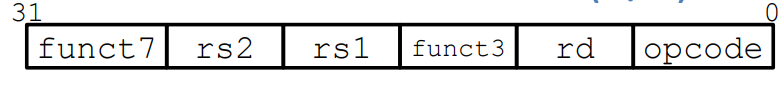

As instruções tipo-R (register-register) utilizam três registradores como input, sendo esses rs2, rs1 e rd registradores de 5 bits.

Todas as instruções tipo-R são classificadas como lógica/aritimética.

**Campo rs1:** primeiro operando (source register 1);

**Campo rs2:** segundo operando (source register 2);

**Campo rd:** destination register - recebe o resultado da computação;

**Campo opcode:** parcialmente especifica a operação, instruções tipo-R têm opcode = 0b0110011;

**Campos funct7 + funct3:** combinados com o opcode, esses dois campos descrevem qual operação deve ser realizada.

As definições básicas de como cada instrução opera sobre os registradores foram programadas em alu.sv. Segue abaixo um exemplo da instrução XOR.

In [ ]:
4'b1001:	    // XOR
		    ALUResult = SrcA ^ SrcB;

# Instruções I-type, i.e. immediates

As instruções tipo-I são muito semelhantes as tipo-R, no entanto ao invés de três registradores como input teremos apenas dois e um valor imediato.

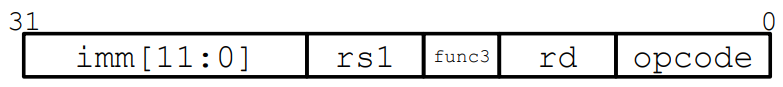

Nota-se que os campos Funct7 e rs2 foram substituídos por imm de 12 bits, logo o que irá definir qual operação deve ser realizada é a junção de Funct3 e opcode.

**Campo imm[11:0]:** é o lugar reservado para um número de 12 bits com sinal. Esse campo é extendido para 32 bits antes da operação aritmética, pois todas as computações são feitas nele.

Assim como tipo-R, temos o source register 1 e destination register.

As instruções de shift imediato utilizam apenas 5 bits menos significativos do valor imediato para fazer a operação. Os outros 7 bits são usados para distinguir entre shifts lógicos dos aritméticos.

Segue um exemplo de implementação do SRLI.

In [ ]:
4'b0101:	    // SRLI
		    ALUResult = SrcA >> SrcB[4:0];

Além disso, as instruções de LOAD também são do tipo-I. O campo imm[11:0] torna-se o offset da instrução, o rs1 é a base e o rd o destino.

O offset de 12 bits é adicionado ao endereço base do registrador rs1 para formar o endereço de memória desejado.

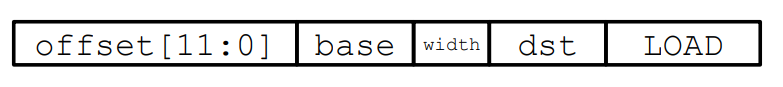

**Campo opcode:** o opcode para instruções load é do formato 0b0000011;

**Campo width:** atua como um Funct3 para diferenciar os tipos de loads.

Suponha que queremos realizar a seguinte operação: **lw x14, 8(x2)**, logo obteremos a seguinte configuração:

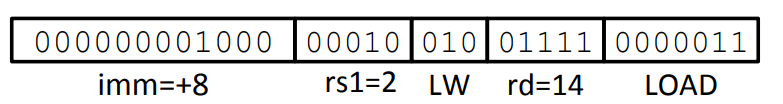

Por fim, temos a instrução JALR que também é do tipo-I, pois, assim como LOAD, utiliza de um offset, registrador base e registrador destino.

Nesse sentido, JALR utiliza o mesmo immediate do aritmético e do LOAD.

A instrução foi implementada seguindo o formato:

**jalr rd, rs1, offset**, onde: PC + 4 é escrito em rd; novo PC é definido como PC = rs1 + offset.


# Instruções S-type, i.e. stores

As instruções tipo-S foram implementadas com dois registradores, rs1 para o endereço base da memória, rs2 para a informação a ser guardada e offset imediato.

Como as operações de store não escrevem no arquivo de registrador o destination register não foi utilizado.

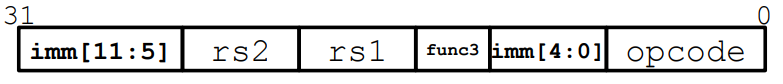

Como instruções store não têm destination register, os 5 bits menos significativos do immediate ocupam o espaço que antes era do rd.

# Instruções B-type, i.e. branching

As instruções de branching foram implementadas de maneira semelhante às de store, ambas usam dois registradores e necessitam especificar um endereço de memória. Além disso, branching não utiliza destination register.

Se não "pegarmos" o branch, o endereço da próxima instrução estará no PC + 4.

Se "pegarmos" o branch a próxima instrução estará no PC + (immediate * 4).

A multiplicação por 4 é essencial devido ao fato que a memória é endereçada em bytes, logo o endereço é sempre um múltiplo de 4 (em bytes).

**obs:** immediate é o número de instruções a mover ou para frente (+) ou para trás (-).

Suponha que desejamos executar o seguinte código:

In [ ]:
loop: beq x19,x10,End
      add x18,x18,x10
      addi x19,x19,-1
      j loop
End:  <target instruction>

A contagem de instrução iniciará após o branch, logo do branch até End são 4 instruções. Multiplicando 4 * 4 temos nosso offset = 16 bytes, então nosso 13-bit immediate, imm[12:0] terá guardado o valor 16.

Lembre-se que imm[0] é descartado, pois sempre será zero, isto é, não há branch para si mesmo.

# Instruções U-type, i.e. upper immediate

Instruções tipo-U lidam com um registrador de destino, um campo imediato de 20 bits e um opcode de 7 bits.

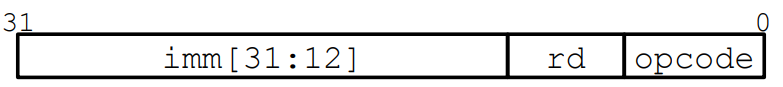

Nesse projeto a única instrução tipo-U implementada foi a LUI (load upper immediate) que escreve os 20 bits mais significativos do destino com o valor imediato e limpa os 12 bits menos significativos.

A implementação foi feita como um sign extend mantendo os 20 bits mais significativos e extendo os 12 bits menos significativos.

Usando uma notação de Verilog a implementação simples seria **{inst[31:12], 12'b0}**.

# Instruções J-type, i.e. jump

A instrução JAL tem uma implementação mais simples. Utilizamos um offset de 20 bits **offset[31:12]** onde a instrução alvo (target instruction) está entre as ±2¹⁹ localizações.

O JAL irá salvar o PC + 4 no registrador rd (return address) e calcular o novo PC como PC = PC + offset.

# Descrição dos Sinais de Controle para cada Classe de Instruções

Será agora descrito os sinais de controle essenciais para cada classe de instruções e como são utilizados.

Os sinais de controle podem ser encontrados em ALUController.sv e alu.sv.

# Sinais das Instruções R-type

Todas as instruções lógico/aritméticas apresentam o mesmo **operation code e ALUOp**, portanto o que distingue uma função de outra são os **sinais em Funct3 e Funct7**.

Logo, pode-se concluir o seguinte:

1)R-type instructions **opcode = 0b0110011**;

2)R-type instructions **ALUOp = 10**;

3)Duas instruções distintas nunca terão Funct7 e Funct3 iguais **simultaneamente**.

Para a classe de instrução tipo-R a ALU executará uma das quatro ações (AND, OR, add ou subtract), a depender dos valores em Funct7 e Funct3.

Em alu.sv é possível encontrar os valores correspondentes a estas operações AND, OR, add e subtract.

**AND = 0000;**

**OR  = 0001;**

**add = 0010;**

**sub = 0011.**

Além disso, para XOR utilizamos **xor = 1001**.


# Sinais das Instruções I-type

I-type instructions são divididas em três: load, immediates e jalr, cada uma com suas peculiaridades.

Todas as instruções de LOAD irão assumir a seguinte característica:

1)LOAD **opcode = 0b0000011**;

2)Todos os loads têm o campo **Funct3 distintos entre si;**

3)**ALUOp = 00**.

A linha de controle da ALU **executa adição** para o cálculo do endereço de memória do LOAD.

As instruções **SLLI, SRLI e SRAI** apresentam a mesma configuração da palavra na memória. Além do opcode, Funct3 e Funct7 essas instruções têm um campo chamado shamt, utilizado para a computação do valor.

Características das instruções imediatas:

1)**opcode = 0b0010011**;

2)**Com exceção das instruções citadas acima**, Funct3 sempre distinto entre si;

3)Para o caso especial das instruções acima, os shifts lógicos dos aritméticos são diferenciados pelo Funct7;

4)**ALUOp = 10**.

Segue abaixo a ALU control lines para SLLI, SRLI, SRAI:

**slli = 0100;**

**srli = 0101;**

**srai = 0111.**

A instrução **JALR** é um caso aparte das I-type, ela tem um **opcode único = 0b1100111**, como ela também opera com endereço de memória sua configuração tem imm[11:0] e ela utiliza da operação **ADD** para calcular este endereço. **Seu Funct3 = 000**.

# Sinais das Instruções S-type

Intruções STORE têm **opcode = 0b0100011**, **ALUOp = 00** (conforme o livro texto). A sua palavra na memória tem o **offset divido em dois**: imm[11:5] e imm[4:0], que combinados formam o 12-bit offset.

Assim como LOAD, STORE utiliza o control line ADD para calcular o endereço de memória.

# Sinais das Instruções B-type

Os branches realizam comparações lógicas, portanto a ALU control line ficou da seguinte maneira:

**less then (a < b?)** = 1100;

**different then (a != b?)** = 1101;

**greater then or equal (a >= b?)** = 1110.

-------

1)**opcode = 0b1100011**;

2)**ALUOp = 01**;

3)**Funct3** sempre distintos entre si;

4)13-bit immediate guarda o target instruction do branch.

# Sinais das Instruções U-type

Nesse projeto a única upper immediate implementada foi a LUI. Assim como o JALR, tem **opcode único = 0b0110111** e **ALUOp = 11**. Não apresenta Funct3 e Funct7.

A control line para **LUI = 1010**;

# Sinais das Instruções J-type

Instrução JAL não apresenta Funct3 e Funct7, o que a distingue é seu **opcode = 0b1101111**.

Assim como JALR, a instrução JAL utiliza ADD para calcular o endereço de memória.

# Descrição das Simulações Realizadas

**Simulação 1:** ADDI, OR, ADD, SLL, SRL, SRA, SLT, SLTI, SLLI, SRLI, SRAI, XORI, ORI, ANDI e XOR

Para a nossa primeira simulação iremos utilizar as instruções presentes em simulation_1 no github ([simulation_1](https://github.com/isabellavittori/projeto_IH/tree/main/sims/simulation_1)).

Segue abaixo o log de simulação gerado pelo ModelSim


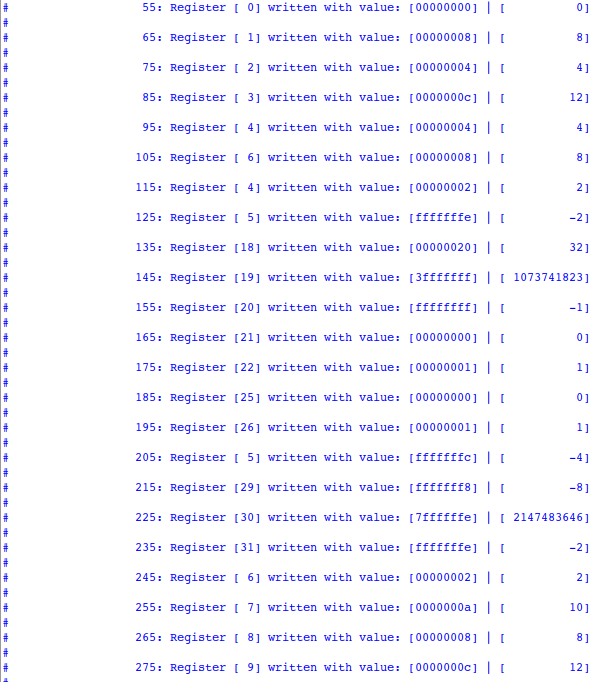

O log de simulação mostra de forma sucinta os estados de cada registrador ao longo da execução do código. A primeira linha é o PC = 0, e a cada linha seguinte PC + 4.

Portanto, pode-se interpretar que cada linha do log corresponde a uma linha da instrução. Vamos analisar o primeiro caso:

In [ ]:
addi x0, x0, 0 //isto é, estamos adicionando um immediate = 0 para rs1 = x0
               // e colocando seu resultado em rd = x0

Logo, o log nos dá o seguinte resultado:

 **55: Register [ 0] written with value: [00000000] | [          0]**

Todas as linhas do log irão assumir esse formato:

**tt: Register [x] written with value: [hhhhhhhh] | [dddddddd]**

Onde **tt** é o tempo de simulação, **x** o número do registrador, **hhhhhhhh** o valor em hexadecimal guardado no registrador e **dddddddd** o mesmo valor em decimal.


**Simulação 2:** SUB, AND e LUI

Os arquivos necessários para a simulação dois podem ser encontrados no seguinte link ([simulation_2](https://github.com/isabellavittori/projeto_IH/tree/main/sims/simulation_2)).

Segue abaixo o log gerado, seguindo o mesmo formato explicado anteriormente.

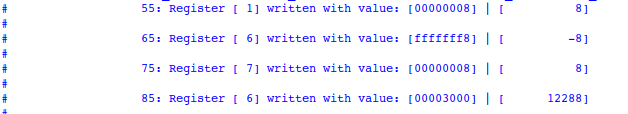

In [ ]:
//analisando o segundo resultado do log

sub x6, x6, x1

//lembre-se que no início de uma simulação os registradores estão escritos com 0
//logo, na linha 2 do código estamos subtraindo 0 - 8
//que a ALU irá interpretar como 0 + (-8)
//portanto, o rd = x6 é escrito com -8

**Simulação 3:** LB, LH e LW

A terceira simulação irá trabalhar com leitura na memória, portanto nosso log irá assumir o seguinte formato:

**tt: Register [x] written with value: [hhhhhhhh] | [dddddddd]**

**tt: Memory [x] read with value: [hhhhhhhh] | [dddddddd]**

Onde, **tt** é o tempo de simulação, **x** representa o número do registrador/endereço de memória, **hhhhhhhh** é o número em hexadecimal guardado no slot do registrador/memória, e **dddddddd** é o mesmo número em decimal.

Segue o link com as informações necessárias para rodar a simulação três ([simulation_3](https://github.com/isabellavittori/projeto_IH/tree/main/sims/simulation_3)).

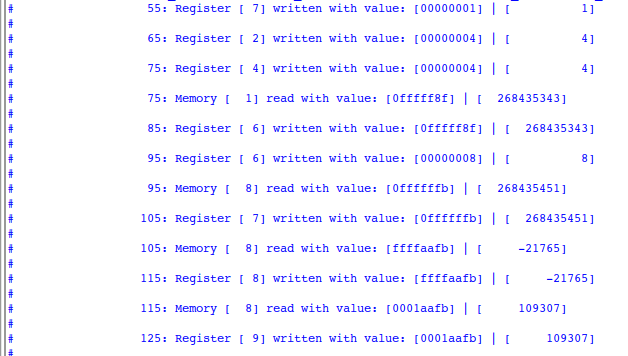

In [ ]:
//analisando linha 4 do código

lb x6, 0(x7)

//nesse caso estamos carregando o que está no endereço offset 0 + x7 para o x6
//como x7 = 1, o endereço de memória é 1, onde tem apenas lixo
//por fim, esse lixo de memória foi escrito em x6

**Simulação 4:** LBU e LHU

Segue o link com as informações necessárias para a simulação quatro ([simulation_4](https://github.com/isabellavittori/projeto_IH/tree/main/sims/simulation_4)).

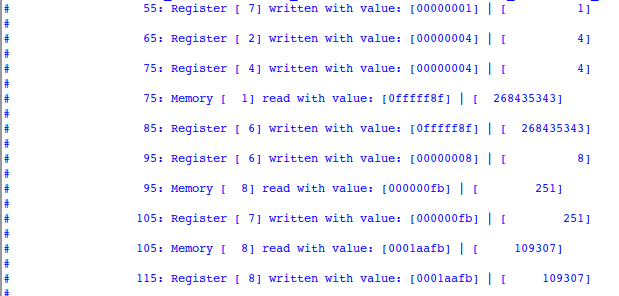

In [ ]:
//vamos analisar linha 6 do código

lbu x7, 0(x6)

//como o x6 está escrito com 8, nosso endereço de memória a ser carregado em x7
//será offset = 0 + 8, resultando no endereço de memória 8
//como estamos lendo os upper bits do endereço 8 da memória
//escrevemos x7 com o valor 251 da memória

**Simulação 5:** JAL e BEQ (taken)

Segue o link ([simulation_5](https://github.com/isabellavittori/projeto_IH/tree/main/sims/simulation_5)).

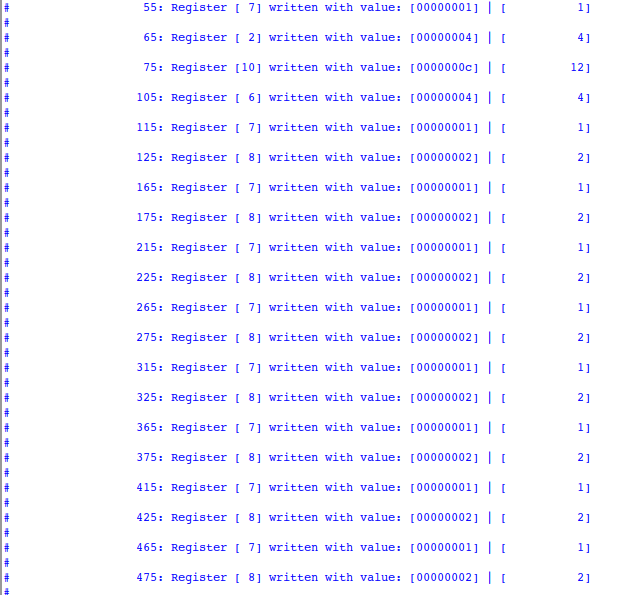

In [ ]:
//vamos analisar a linha 3 do código

jal x10, 8

//a instrução jump and link irá pegar o PC + 4 e guardar no x10 e atualizar
//o valor de PC para PC = PC + offset, nesse caso ficaria PC = 8 + 8 = 16
//16 é o PC com a instrução alvo, logo da linha 3 ele irá pular para a linha
//5 do código

**Simulação 6:** BEQ (not taken)

Segue o link ([simulation_6](https://github.com/isabellavittori/projeto_IH/tree/main/sims/simulation_6)).

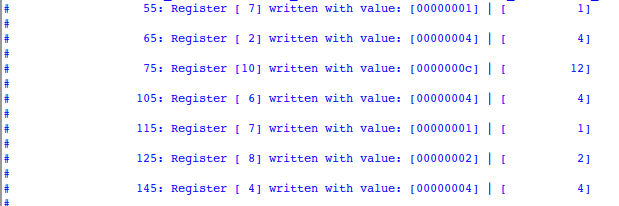

In [ ]:
//vamos analisar a linha 8 do código

beq x8, x7, -8

//a instrução BEQ funciona de maneira bem direta, comparando dois valores checar
//se são iguais
//nesse caso, os valores comparados estão no x7 e x8, respectivamente 1 e 2
//se fossem iguais iriámos "pular" duas instruções para trás, caso contrário
//o branch não é "pego" e a execução continua normalmente

**Simulação 7:** BNE (taken)

Segue o link ([simulation_7](https://github.com/isabellavittori/projeto_IH/tree/main/sims/simulation_7)).

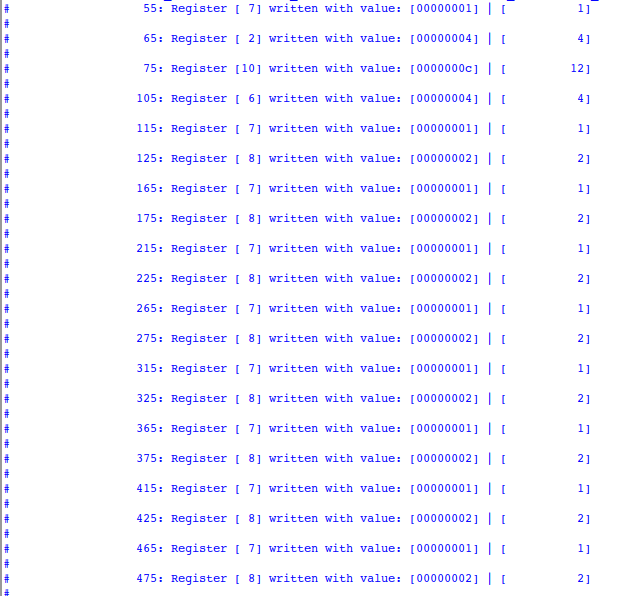

In [ ]:
//vamos analisar a linha 8 do código

bne x8, x7, -8

//BNE compara os valores nos registradores x8 e x7 e caso sejam diferentes irá
//pular -8 instruções, ou seja da linha 8 irá pular para a linha 6

**Simulação 8:** BLT (taken)

Segue o link ([simulation_8](https://github.com/isabellavittori/projeto_IH/tree/main/sims/simulation_8)).

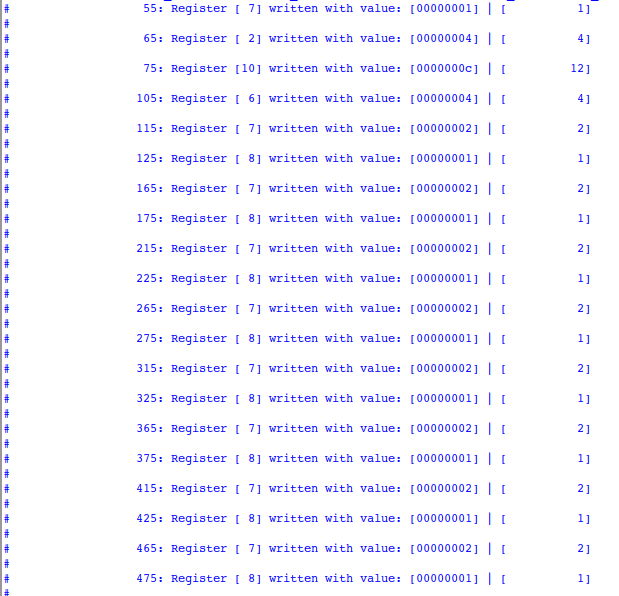

In [ ]:
//vamos analisar a linha 8 do código

blt x8, x7, -8

//BLT irá para a instrução alvo caso rs2 for menor que rs1, neste caso
//se o valor em x8 for menor que o valor em x7 iremos pular -8 instruções
//da linha 8 para a linha 6

**Simulação 9:** BGE (taken)

Segue o link ([simulation_9](https://github.com/isabellavittori/projeto_IH/tree/main/sims/simulation_9)).

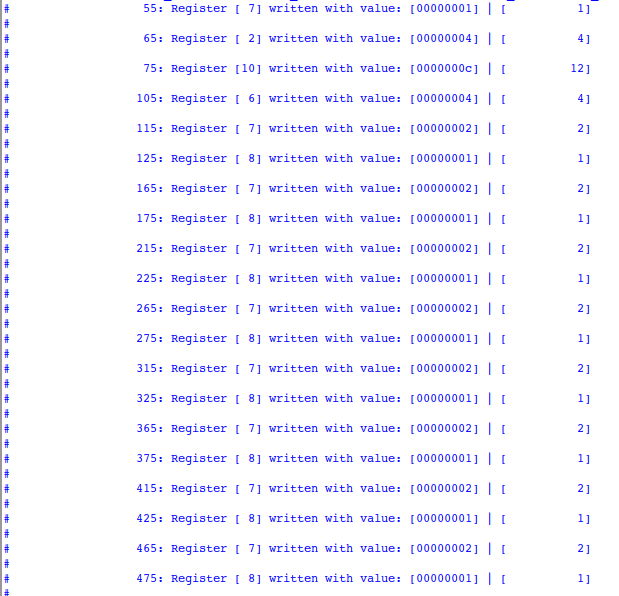

In [ ]:
//vamos analisar a linha 8

bge x7, x8, -8

//BGE irá para a instrução alvo caso rs2 for maior que rs1, neste caso
//se o valor em x7 for maior que em x8, como é verdadeiro iremos pular
//da linha 8 para a linha 6

**Simulation 10:** JALR

Segue o link ([simulation_10](https://github.com/isabellavittori/projeto_IH/tree/main/sims/simulation_10)).

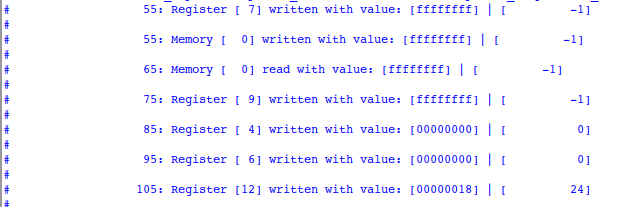

In [ ]:
//vamos analisar a linha 6 do código

jalr x12, x0, 12

//JALR irá pegar o valor do PC atual +4 e colocar no rd, neste caso
//o PC = 20 e rd é x12, portanto x12 terá o valor 24 e novo PC
//será PC = rs1 + offset

**Simulation 11:** SW

Segue o link com os arquivos necessários ([simulation_11](https://github.com/isabellavittori/projeto_IH/tree/main/sims/simulation_11)).

A seguinte simulação irá trabalhar com leitura e escrita na memória, portanto nosso log assumirá o seguinte formato:

**tt: Register [x] written with value: [hhhhhhhh] | [dddddddd]**

**tt: Memory [x] read with value: [hhhhhhhh] | [dddddddd]**

**tt: Memory [x] written with value: [hhhhhhhh] | [dddddddd]**

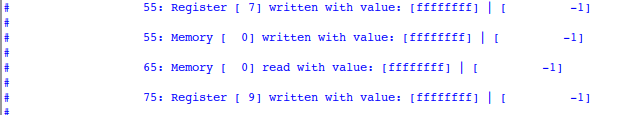

In [ ]:
//vamos analisar as linhas 2 e 3 do código

sw x7, 0(x0)
lw x9, 0(x0)

//SW irá guardar o conteúdo da palavra de rs2 para o endereço em offset + rs1
//na linha 1 o registrador x7 foi escrito com -1, portanto em 0(x0)
//terá o valor -1 escrito

**Simulação 12:** SB, SH

Segue o link ([simulation_12](https://github.com/isabellavittori/projeto_IH/tree/main/sims/simulation_12)).

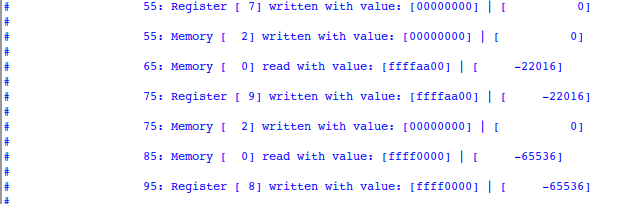

# Conclusão

Os resultados obtidos conforme apresentados na introdução foram alcançados por meio de execuções anteriores do código ao longo do desenvolvimento do projeto.

Todas as simulações ocorreram normalmente e apresentaram os resultados esperados. Com isso, conclui-se o relatório.